In [1]:
import itk
print(itk.__version__)

5.4.0


In [2]:
# Chemins des fichiers de scan
scan1_path = 'Data/case6_gre1.nrrd'
scan2_path = 'Data/case6_gre2.nrrd'

# Charger les images
PixelType = itk.F
scan1 = itk.imread(scan1_path, PixelType)
scan2 = itk.imread(scan2_path, PixelType)

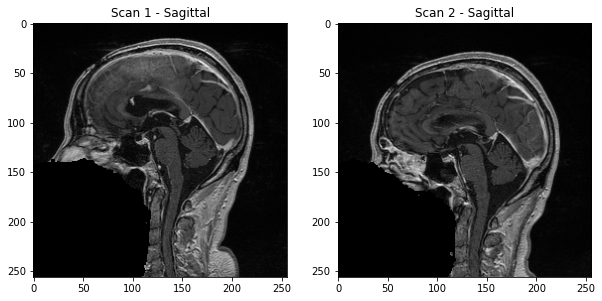

In [3]:
import matplotlib.pyplot as plt

# Convertir les images en tableaux numpy
img1 = itk.GetArrayFromImage(scan1)
img2 = itk.GetArrayFromImage(scan2)

slice_index = img1.shape[0] // 2

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Scan 1 - Sagittal")
plt.imshow(img1[slice_index, :, :], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Scan 2 - Sagittal")
plt.imshow(img2[slice_index, :, :], cmap='gray')

plt.show()


In [4]:
dimension = scan1.GetImageDimension()
FixedImageType = type(scan1)
MovingImageType = type(scan2)

In [5]:
# Initialiser la transformation
TransformType = itk.TranslationTransform[itk.D, dimension]
initial_transform = TransformType.New()


# Initialiser la métrique
metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()
fixed_interpolation = itk.LinearInterpolateImageFunction[FixedImageType, itk.D].New()
metric.SetFixedInterpolator(fixed_interpolation)
metric.SetFixedImage(scan1)
metric.SetMovingImage(scan2)


# Initialiser l'optimiseur
optimizer = itk.RegularStepGradientDescentOptimizerv4.New()

optimizer.SetLearningRate(1)
optimizer.SetMinimumStepLength(0.01)
optimizer.SetNumberOfIterations(400)


# Configurer le recalage
RegistrationType = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType]
registration = RegistrationType.New()

registration.SetFixedImage(scan1)
registration.SetMovingImage(scan2)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.SetInitialTransform(initial_transform)


# Calculer la valeur de la métrique avant le recalage
metric.Initialize()
initial_metric_value = metric.GetValue()
print(f"Metric value before transformation: {initial_metric_value}")

# Effectuer le recalage
registration.Update()

# Appliquer la transformation
resampler = itk.ResampleImageFilter.New(
    Input=scan2,
    Transform=registration.GetTransform(),
    UseReferenceImage=True,
    ReferenceImage=scan1
)
aligned_image = resampler.GetOutput()

# Calculer la valeur de la métrique après le recalage
final_metric_value = metric.GetValue()
print(f"Metric value after transformation: {final_metric_value}")

# Sauvegarder l'image recalée
itk.imwrite(aligned_image, 'aligned_image.nrrd')

aligned_image

Metric value before transformation: 55130.19978782906
Metric value after transformation: 11164.275235614887


<itk.itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x0000021C48C386C0> >

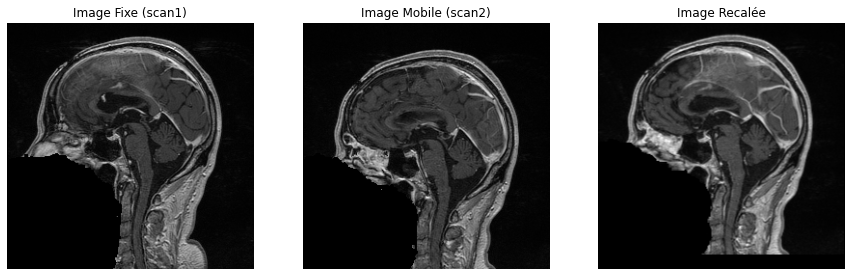

In [6]:
# Convertir l'image recalée en tableau numpy
aligned_img = itk.GetArrayFromImage(aligned_image)

# Visualiser les images avant et après le recalage
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img1[slice_index, :, :], cmap='gray')
axes[0].set_title('Image Fixe (scan1)')
axes[0].axis('off')

axes[1].imshow(img2[slice_index, :, :], cmap='gray')
axes[1].set_title('Image Mobile (scan2)')
axes[1].axis('off')

axes[2].imshow(aligned_img[slice_index, :, :], cmap='gray')
axes[2].set_title('Image Recalée')
axes[2].axis('off')

plt.show()

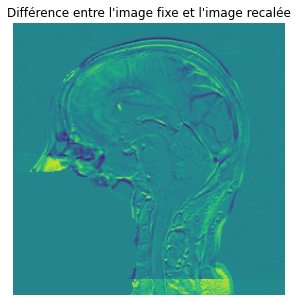

In [7]:
diff = img1[slice_index] - aligned_img[slice_index]
plt.figure(figsize=(10, 5))
plt.imshow(diff)
plt.title('Différence entre l\'image fixe et l\'image recalée')
plt.axis('off')
plt.show()